### Read chart image to interpret trend lines within

### using OpenCV

In [1]:
# !pip install opencv-python

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, transform


C:\Users\kenny\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
def generate_chart_description(file_path):
    
    # Load the image
    image = cv2.imread(file_path)

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for red color
    lower_red = np.array([0, 100, 100])  # Adjust these values as needed
    upper_red = np.array([10, 255, 255])

    # Define the lower and upper bounds for green color
    lower_green = np.array([40, 40, 40])  # Adjust these values as needed
    upper_green = np.array([85, 255, 255])

    # Threshold the HSV image to get only red or green colors
    mask_red = cv2.inRange(hsv, lower_red, upper_red)
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Combine masks for red and green parts
    mask_combined = cv2.bitwise_or(mask_red, mask_green)

    # Find contours in the combined mask
    contours_combined, _ = cv2.findContours(mask_combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select the contour with the largest area
    if contours_combined:
        largest_contour = max(contours_combined, key=cv2.contourArea)
        mask_combined = np.zeros_like(mask_combined)
        cv2.drawContours(mask_combined, [largest_contour], -1, 255, -1)

    # Bitwise-AND mask and original image
    res_combined = cv2.bitwise_and(image, image, mask=mask_combined)

    # Convert the combined image to grayscale
    res_combined_gray = cv2.cvtColor(res_combined, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = feature.canny(res_combined_gray, sigma=3)

    # Detect lines using Hough Line Transform
    lines = transform.probabilistic_hough_line(edges, threshold=1, line_length=1, line_gap=3)

    # Initialize lists to store slopes
    valid_lines = []

    # Adjust the threshold values for filtering out horizontal and vertical lines
    horizontal_threshold = 0  # Adjust this value as needed
    vertical_threshold = 80  # Adjust this value as needed

    # Draw the detected lines on the original image and calculate slopes
    fig, ax = plt.subplots()
    ax.imshow(res_combined, cmap=plt.cm.gray)
    valid_lines = []  # Store valid lines
    if lines is not None:
        for line in lines:
            p0, p1 = line

            # Calculate slope
            if p1[0] - p0[0] != 0:  # Check for division by zero
                slope = abs((p1[1] - p0[1]) / (p1[0] - p0[0]))

                # Check if both y-values are less than or equal to 200
                if p0[1] <= 200 and p1[1] <= 200:
                    # Ignore lines with slopes close to zero (horizontal lines)
                    # and lines with infinite slopes (vertical lines)
                    if slope > horizontal_threshold and slope < vertical_threshold:
                        valid_lines.append(line)
                        ax.plot((p0[0], p1[0]), (p0[1], p1[1]), color='red')

    # Show the plot
#     plt.show()

      
    # Determine x-coordinates of red lines
    red_line_x_coords = [min(p0[0], p1[0]) for p0, p1 in valid_lines]

    # Sort the x-coordinates
    red_line_x_coords.sort()

    # Divide the x-axis into four parts
    quarter_points = np.linspace(min(red_line_x_coords), max(red_line_x_coords), num=5)

    # Initialize lists to store descriptions for each quarter
    descriptions = []

    # Iterate over quarters
    for i in range(len(quarter_points) - 1):
        quarter_start = quarter_points[i]
        quarter_end = quarter_points[i + 1]

        # Filter lines within the current quarter
        lines_in_quarter = [line for line in valid_lines if min(line[0][0], line[1][0]) >= quarter_start and max(line[0][0], line[1][0]) <= quarter_end]

        # Get the first and last line segments within the quarter
        if lines_in_quarter:
            first_line = min(lines_in_quarter, key=lambda line: min(line[0][0], line[1][0]))
            last_line = max(lines_in_quarter, key=lambda line: min(line[0][0], line[1][0]))

            # Compare y-values of the first and last line segments
            if abs(first_line[0][1] - last_line[1][1]) / max(first_line[0][1], last_line[1][1]) <= 0.05:
                descriptions.append("the stock price exhibits little variation, suggesting a period of consolidation")
            elif first_line[0][1] < last_line[1][1]:
                descriptions.append("a decline in stock value that could be due to wane in investor confidence, bearish market sentiment or economic headwinds")
            else:
                descriptions.append("an increase in stock value that could be due to optimism in the market or bullish market conditions")
        else:
            # No lines in the quarter
            descriptions.append("no lines in this quarter")

        # Plot vertical lines at the start and end of the quarter
        plt.axvline(x=quarter_start, color='blue', linestyle='--', linewidth=1)
        plt.axvline(x=quarter_end, color='blue', linestyle='--', linewidth=1)

        # Plot markers for the first and last points of each quarter
        if lines_in_quarter:
            plt.scatter(first_line[0][0], first_line[0][1], color='green', marker='o')
            plt.scatter(last_line[1][0], last_line[1][1], color='red', marker='o')

    # Plot the chart
    plt.imshow(res_combined, cmap=plt.cm.gray)

    # # Print descriptions for each quarter
    # for i, description in enumerate(descriptions):
    #     quarter_number = i + 1
    #     quarter_word = convert_to_words(quarter_number)
    #     if quarter_number == 1:
    #         print(f"The first quarter of the chart shows that {description}")
    #     elif quarter_number == 2:
    #         print(f"In the second quarter, {description}")
    #     elif quarter_number == 3:
    #         print(f"The third quarter indicates {description}")
    #     elif quarter_number == 4:
    #         print(f"Finally, the fourth quarter reveals {description}")

    # Print description for the fourth quarter
    quarter_number = 4
    quarter_word = convert_to_words(quarter_number)
    print(f"The tailend quarter reveals {descriptions[quarter_number - 1]}")

    # Show the plot
    plt.show()

In [4]:
# Convert quarter numbers to words
def convert_to_words(number):
    if number == 1:
        return "first"
    elif number == 2:
        return "second"
    elif number == 3:
        return "third"
    elif number == 4:
        return "fourth"
    else:
        return ""

The tailend quarter reveals a decline in stock value that could be due to wane in investor confidence, bearish market sentiment or economic headwinds


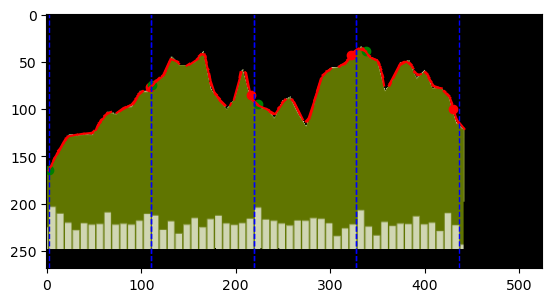

In [5]:
# Example usage:
file_path = 'AAPL/1y_chart_20240308_1012.png'
generate_chart_description(file_path)
